# Statistical Power Analysis Plots

Visualizing power analysis results from the rl_stats methodology.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the power analysis results
power_df = pd.read_csv('/n/home09/annabelma/rl_final_proj/stat_results/power_empirical_df.csv')

print(f"Loaded {len(power_df)} power analysis results")
print(f"\nColumns: {list(power_df.columns)}")
print(f"\nUnique tasks: {sorted(power_df['task'].unique())}")
print(f"Unique algorithms pairs: {power_df.groupby(['algo1', 'algo2']).size().shape[0]}")
print(f"Unique tests: {sorted(power_df['test'].unique())}")
print(f"Effect sizes (epsilon): {sorted(power_df['epsilon'].unique())}")
print(f"Sample sizes: {sorted(power_df['target_n'].unique())}")
print(f"Alpha levels: {sorted(power_df['alpha'].unique())}")

display(power_df.head(10))

Loaded 1080 power analysis results

Columns: ['task', 'algo1', 'algo2', 'test', 'alpha', 'epsilon', 'target_n', 'power', 'se']

Unique tasks: ['Ant-v5', 'HalfCheetah-v5', 'Hopper-v5', 'Humanoid-v5', 'Walker2d-v5']
Unique algorithms pairs: 1
Unique tests: ['Mann-Whitney', 'Ranked t-test', 'Welch t-test', 'bootstrap', 'permutation', 't-test']
Effect sizes (epsilon): [0.5, 1.0, 2.0]
Sample sizes: [2, 3, 5, 10, 20, 30]
Alpha levels: [0.01, 0.05]


,task,algo1,algo2,test,alpha,epsilon,target_n,power,se
0,Hopper-v5,SAC,TD3,t-test,0.05,0.5,2,0.182,0.012201
1,Hopper-v5,SAC,TD3,Welch t-test,0.05,0.5,2,0.094,0.009228
2,Hopper-v5,SAC,TD3,Mann-Whitney,0.05,0.5,2,0.000,0.000000
3,Hopper-v5,SAC,TD3,Ranked t-test,0.05,0.5,2,0.000,0.000000
4,Hopper-v5,SAC,TD3,bootstrap,0.05,0.5,2,0.645,0.015132
5,Hopper-v5,SAC,TD3,permutation,0.05,0.5,2,0.683,0.014714
6,Hopper-v5,SAC,TD3,t-test,0.05,0.5,3,0.226,0.013226
7,Hopper-v5,SAC,TD3,Welch t-test,0.05,0.5,3,0.159,0.011564
8,Hopper-v5,SAC,TD3,Mann-Whitney,0.05,0.5,3,0.000,0.000000
9,Hopper-v5,SAC,TD3,Ranked t-test,0.05,0.5,3,0.153,0.011384


In [8]:
# ============================================================================
# Plot 1: Power vs Sample Size (aggregated across all tasks/pairs)
# ============================================================================

# Color map for tests (matching paper style)
test_colors = {
    't-test': '#1f77b4',           # blue
    'Welch t-test': '#ff7f0e',     # orange
    'Mann-Whitney': '#2ca02c',     # green
    'Ranked t-test': '#9467bd',    # purple
    'bootstrap': '#17becf',        # cyan
    'permutation': '#bcbd22'       # yellow-green
}

tests_list = ['t-test', 'Welch t-test', 'Mann-Whitney', 'Ranked t-test', 'bootstrap', 'permutation']

aggregated_plot_dir = '/n/home09/annabelma/rl_final_proj/power_plots/aggregated'
os.makedirs(aggregated_plot_dir, exist_ok=True)

plots_saved = 0

# Create plots for each (alpha, epsilon) combination
for alpha in sorted(power_df['alpha'].unique()):
    for epsilon in sorted(power_df['epsilon'].unique()):
        # Filter data
        subset = power_df[(power_df['alpha'] == alpha) & (power_df['epsilon'] == epsilon)]
        if len(subset) == 0:
            continue
        
        # Aggregate across tasks and algorithm pairs
        plot_data = subset.groupby(['test', 'target_n']).agg({
            'power': 'mean',
            'se': 'mean'
        }).reset_index()
        
        # Create figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        # Plot each test
        for test_name in tests_list:
            test_data = plot_data[plot_data['test'] == test_name].sort_values('target_n')
            if len(test_data) > 0:
                color = test_colors.get(test_name, '#000000')
                ax.plot(test_data['target_n'], test_data['power'], 
                       marker='o', label=test_name, linewidth=2, color=color, markersize=6)
                # Add error bars
                ax.errorbar(test_data['target_n'], test_data['power'], 
                           yerr=test_data['se'], 
                           fmt='none', color=color, alpha=0.3, capsize=3)
        
        # Add power = 0.8 threshold line
        ax.axhline(y=0.8, color='red', linestyle='--', linewidth=2, 
                  label='Power = 0.8 (target)', zorder=0)
        
        # Formatting
        ax.set_xlabel('Sample size N (log scale)', fontsize=12)
        ax.set_ylabel('Statistical Power (1 - β*)', fontsize=12)
        ax.set_title(f'Power vs Sample Size\nEffect size ε = {epsilon}, α = {alpha}', 
                    fontsize=14, fontweight='bold')
        ax.set_xscale('log')
        
        # Set x-axis ticks
        available_n = sorted(plot_data['target_n'].unique())
        ax.set_xticks(available_n)
        ax.set_xticklabels([str(int(n)) for n in available_n])
        
        # Y-axis: 0 to 1
        ax.set_ylim([0, 1.05])
        ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        
        ax.grid(True, alpha=0.3, which='both')
        ax.legend(loc='lower right', frameon=True, fontsize=10, ncol=2)
        
        plt.tight_layout()

        filename = f"power_aggregated_alpha{alpha:.2f}_eps{epsilon:.1f}.png"
        filepath = os.path.join(aggregated_plot_dir, filename)
        plt.savefig(filepath, bbox_inches='tight', dpi=150)
        plt.close()
        
        # Display plot
        plt.show()
        
        # Save plot
        
        plots_saved += 1
        print(f"Plot created and saved for ε = {epsilon}, α = {alpha}")

print(f"\n{'='*60}")
print(f"Saved {plots_saved} aggregated power plots to: {aggregated_plot_dir}")
print(f"{'='*60}")

Plot created and saved for ε = 0.5, α = 0.01
Plot created and saved for ε = 1.0, α = 0.01
Plot created and saved for ε = 2.0, α = 0.01
Plot created and saved for ε = 0.5, α = 0.05
Plot created and saved for ε = 1.0, α = 0.05
Plot created and saved for ε = 2.0, α = 0.05

Saved 6 aggregated power plots to: /n/home09/annabelma/rl_final_proj/power_plots/aggregated


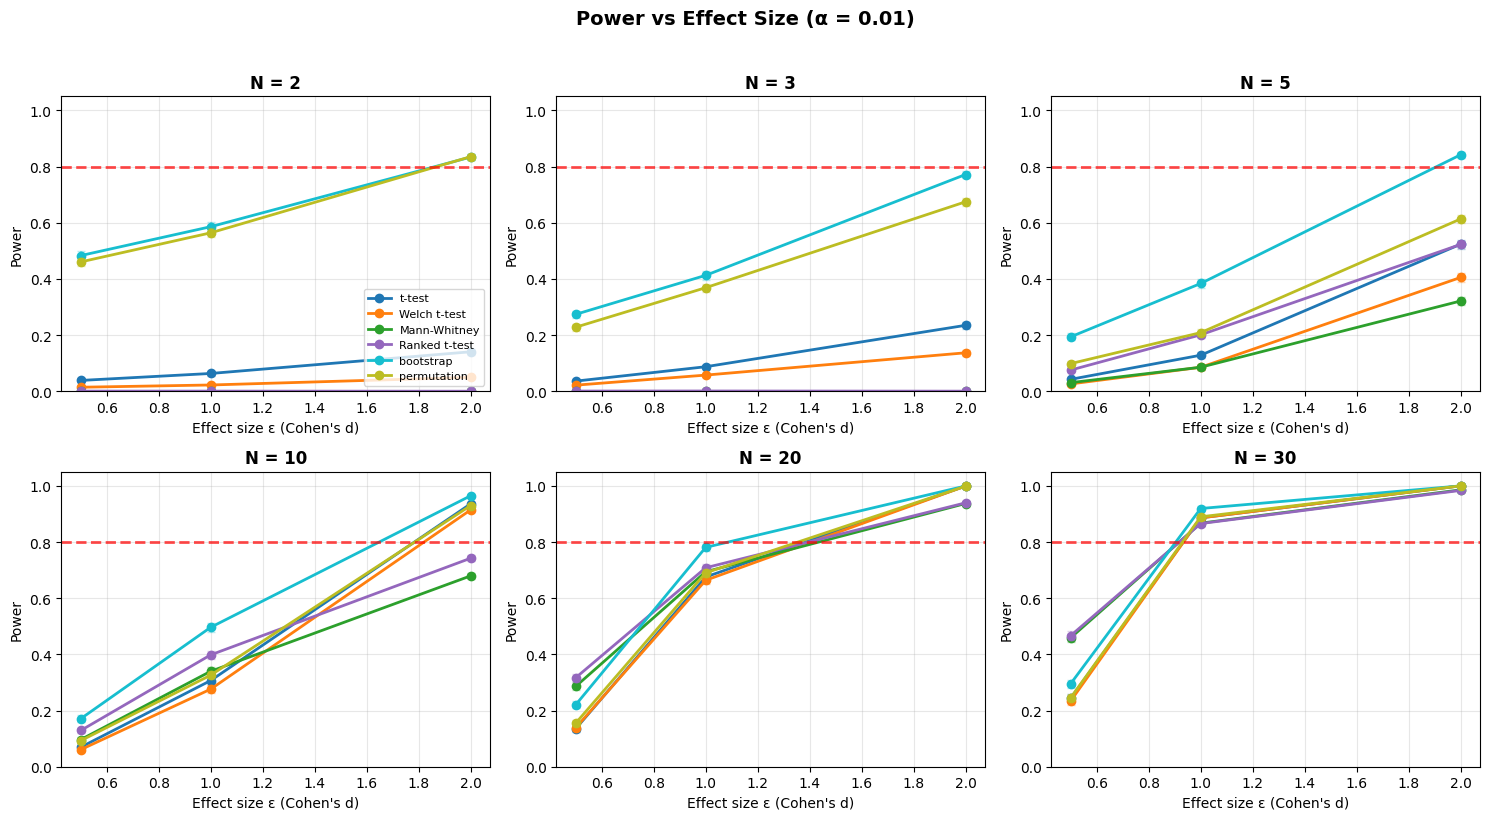

Plot created for α = 0.01


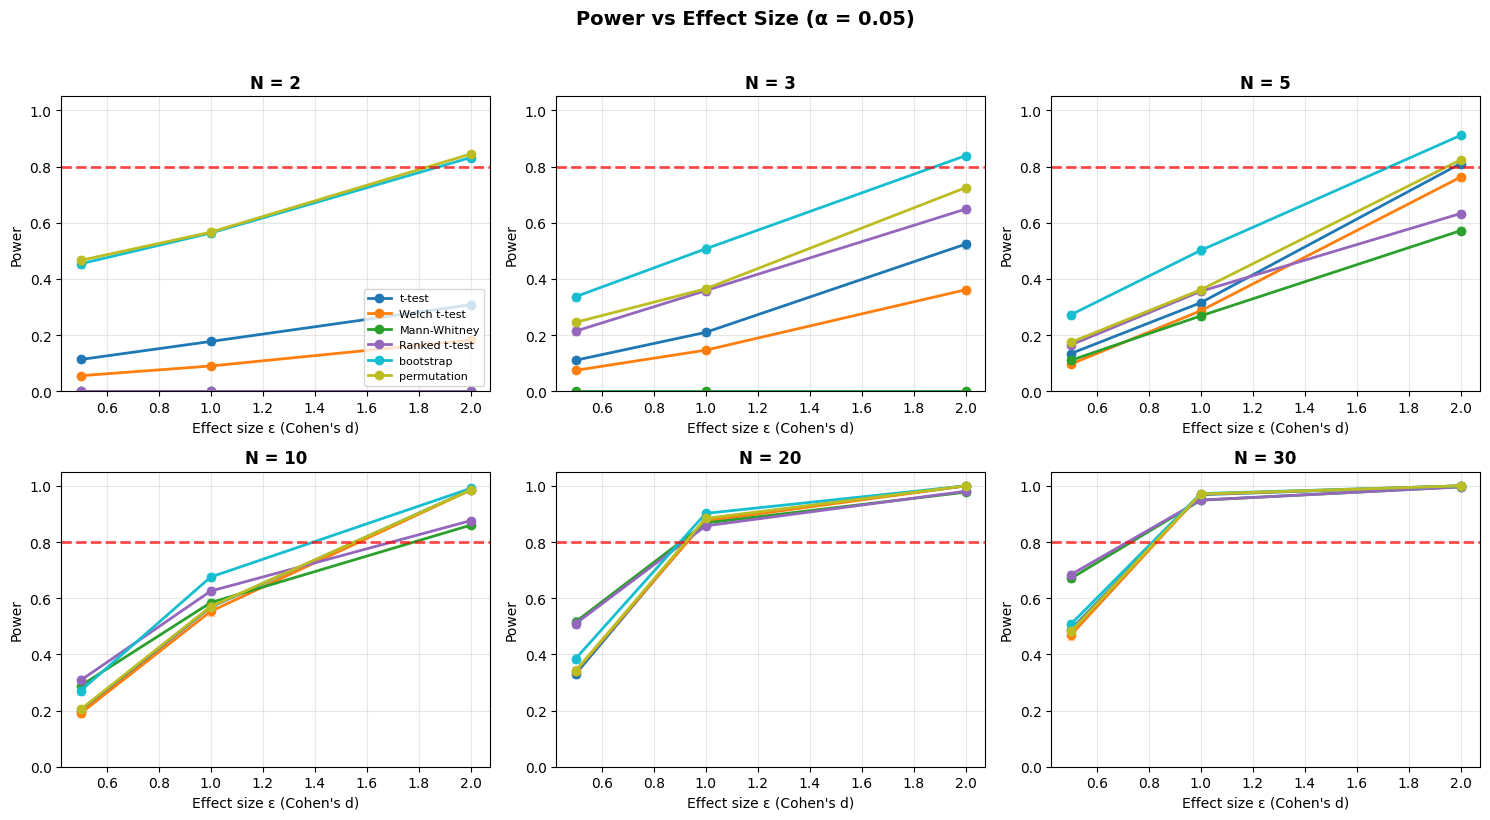

Plot created for α = 0.05


In [6]:
# ============================================================================
# Plot 2: Power vs Effect Size (for different sample sizes)
# ============================================================================

for alpha in sorted(power_df['alpha'].unique()):
    # Filter data
    subset = power_df[power_df['alpha'] == alpha]
    if len(subset) == 0:
        continue
    
    # Aggregate across tasks and algorithm pairs
    plot_data = subset.groupby(['test', 'epsilon', 'target_n']).agg({
        'power': 'mean',
        'se': 'mean'
    }).reset_index()
    
    # Create subplot for each sample size
    sample_sizes = sorted(plot_data['target_n'].unique())
    n_cols = min(3, len(sample_sizes))
    n_rows = (len(sample_sizes) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)
    axes = axes.flatten()
    
    for idx, n in enumerate(sample_sizes):
        ax = axes[idx]
        n_data = plot_data[plot_data['target_n'] == n]
        
        for test_name in tests_list:
            test_data = n_data[n_data['test'] == test_name].sort_values('epsilon')
            if len(test_data) > 0:
                color = test_colors.get(test_name, '#000000')
                ax.plot(test_data['epsilon'], test_data['power'], 
                       marker='o', label=test_name, linewidth=2, color=color, markersize=6)
                ax.errorbar(test_data['epsilon'], test_data['power'], 
                           yerr=test_data['se'], 
                           fmt='none', color=color, alpha=0.3, capsize=3)
        
        # Add power = 0.8 threshold line
        ax.axhline(y=0.8, color='red', linestyle='--', linewidth=2, alpha=0.7)
        
        ax.set_xlabel('Effect size ε (Cohen\'s d)', fontsize=10)
        ax.set_ylabel('Power', fontsize=10)
        ax.set_title(f'N = {int(n)}', fontsize=12, fontweight='bold')
        ax.set_ylim([0, 1.05])
        ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.grid(True, alpha=0.3)
        
        if idx == 0:
            ax.legend(loc='lower right', fontsize=8)
    
    # Hide unused subplots
    for idx in range(len(sample_sizes), len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f'Power vs Effect Size (α = {alpha})', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"Plot created for α = {alpha}")

In [9]:
# ============================================================================
# Generate Individual Power Plots for Each Algorithm Pair and Task
# ============================================================================

print("="*60)
print("Generating individual Power plots for each algorithm pair and task")
print("="*60)

# Create output directory for plots
plot_dir = '/n/home09/annabelma/rl_final_proj/power_plots'
os.makedirs(plot_dir, exist_ok=True)

# Get all unique combinations
unique_combos = power_df.groupby(['task', 'algo1', 'algo2', 'alpha', 'epsilon']).size().reset_index()
print(f"\nFound {len(unique_combos)} unique (task, algo1, algo2, alpha, epsilon) combinations")

plots_created = 0

# Generate plot for each combination
for idx, row in unique_combos.iterrows():
    task = row['task']
    algo1 = row['algo1']
    algo2 = row['algo2']
    alpha = row['alpha']
    epsilon = row['epsilon']
    
    # Filter data for this combination
    combo_data = power_df[
        (power_df['task'] == task) &
        (power_df['algo1'] == algo1) &
        (power_df['algo2'] == algo2) &
        (power_df['alpha'] == alpha) &
        (power_df['epsilon'] == epsilon)
    ]
    
    if len(combo_data) == 0:
        continue
    
    # Group by test and target_n
    plot_data = combo_data.groupby(['test', 'target_n']).agg({
        'power': 'mean',
        'se': 'mean'
    }).reset_index()
    
    if len(plot_data) == 0:
        continue
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Plot each test
    for test_name in tests_list:
        test_data = plot_data[plot_data['test'] == test_name].sort_values('target_n')
        if len(test_data) > 0:
            color = test_colors.get(test_name, '#000000')
            ax.plot(test_data['target_n'], test_data['power'], 
                   marker='o', label=test_name, linewidth=2, color=color, markersize=6)
            # Add error bars
            ax.errorbar(test_data['target_n'], test_data['power'], 
                       yerr=test_data['se'], 
                       fmt='none', color=color, alpha=0.3, capsize=3)
    
    # Add power = 0.8 threshold line
    ax.axhline(y=0.8, color='red', linestyle='--', linewidth=2, 
              label='Power = 0.8', zorder=0)
    
    # Formatting
    ax.set_xlabel('Sample size N (log scale)', fontsize=12)
    ax.set_ylabel('Statistical Power (1 - β*)', fontsize=12)
    ax.set_title(f'Power vs Sample Size: {task}\n{algo1} vs {algo2} (α = {alpha}, ε = {epsilon})', 
                fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    
    # Set x-axis ticks
    available_n = sorted(plot_data['target_n'].unique())
    ax.set_xticks(available_n)
    ax.set_xticklabels([str(int(n)) for n in available_n])
    
    # Y-axis: 0 to 1
    ax.set_ylim([0, 1.05])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    ax.grid(True, alpha=0.3, which='both')
    ax.legend(loc='lower right', frameon=True, fontsize=10, ncol=2)
    
    plt.tight_layout()
    
    # Save plot
    safe_task = task.replace('/', '_').replace('-', '_')
    safe_algo1 = algo1.replace('/', '_')
    safe_algo2 = algo2.replace('/', '_')
    filename = f"power_{safe_task}_{safe_algo1}_vs_{safe_algo2}_alpha{alpha:.2f}_eps{epsilon:.1f}.png"
    filepath = os.path.join(plot_dir, filename)
    plt.savefig(filepath, bbox_inches='tight', dpi=150)
    plt.close()
    
    plots_created += 1
    
    # Show progress every 20 plots
    if plots_created % 20 == 0:
        print(f"Created {plots_created} plots...")

print(f"\n{'='*60}")
print(f"Created {plots_created} individual Power plots")
print(f"Plots saved to: {plot_dir}")
print(f"{'='*60}")

Generating individual Power plots for each algorithm pair and task

Found 30 unique (task, algo1, algo2, alpha, epsilon) combinations
Created 20 plots...

Created 30 individual Power plots
Plots saved to: /n/home09/annabelma/rl_final_proj/power_plots


In [10]:
# ============================================================================
# Summary: Sample size needed to achieve 80% power
# ============================================================================

print("="*60)
print("Sample size needed to achieve 80% power")
print("="*60)

# For each test and effect size, find minimum N where power >= 0.8
results = []

for alpha in sorted(power_df['alpha'].unique()):
    for epsilon in sorted(power_df['epsilon'].unique()):
        for test_name in tests_list:
            subset = power_df[
                (power_df['alpha'] == alpha) & 
                (power_df['epsilon'] == epsilon) &
                (power_df['test'] == test_name)
            ]
            
            # Average power across all tasks and pairs for each sample size
            avg_power = subset.groupby('target_n')['power'].mean().reset_index()
            
            # Find minimum N where power >= 0.8
            high_power = avg_power[avg_power['power'] >= 0.8]
            if len(high_power) > 0:
                min_n = high_power['target_n'].min()
            else:
                min_n = '>30'  # or whatever the max sample size is
            
            results.append({
                'alpha': alpha,
                'epsilon': epsilon,
                'test': test_name,
                'min_n_for_80pct_power': min_n
            })

results_df = pd.DataFrame(results)

# Pivot table for nice display
for alpha in sorted(power_df['alpha'].unique()):
    print(f"\n--- Alpha = {alpha} ---")
    pivot = results_df[results_df['alpha'] == alpha].pivot(
        index='test', 
        columns='epsilon', 
        values='min_n_for_80pct_power'
    )
    print(pivot.to_string())

Sample size needed to achieve 80% power

--- Alpha = 0.01 ---
epsilon        0.5 1.0 2.0
test                      
Mann-Whitney   >30  30  20
Ranked t-test  >30  30  20
Welch t-test   >30  30  10
bootstrap      >30  30   2
permutation    >30  30   2
t-test         >30  30  10

--- Alpha = 0.05 ---
epsilon        0.5 1.0 2.0
test                      
Mann-Whitney   >30  20  10
Ranked t-test  >30  20  10
Welch t-test   >30  20  10
bootstrap      >30  20   2
permutation    >30  20   2
t-test         >30  20   5
